### Обучение автоэнкодера MNIST обратным распостранением с оптимизатором


In [ ]:
from typing import Callable, Tuple

from keras.datasets import mnist

from math import ceil
from matplotlib import pyplot as plt
import numpy as np

import sklearn.datasets
import sklearn.preprocessing
import sklearn.metrics

from tqdm import tqdm

type Nums = np.ndarray[np.number]
type NumsToNums = Callable[[Nums], Nums]
type NumsNumsToNums = Callable[[Nums, Nums], Nums]

np.set_printoptions(formatter={"float": lambda x: "{0:0.3f}".format(x)})

Загрузка датасета и предобработка датасета


In [88]:
(train_x, train_y), (test_x, test_y) = mnist.load_data()

train_x = train_x / 255
test_x = test_x / 255

train_x.resize(60000, 784)
test_x.resize(10000, 784)

train_x.shape, train_y.shape

((60000, 784), (60000,))

In [89]:
digit_to_autoencoded_mapping = {
    0: [
        [1, 1, 1],
        [1, 0, 1],
        [1, 0, 1],
        [1, 0, 1],
        [1, 1, 1],
    ],
    1: [[0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]],
    2: [[1, 1, 1], [0, 0, 1], [1, 1, 1], [1, 0, 0], [1, 1, 1]],
    3: [[1, 1, 1], [0, 0, 1], [1, 1, 1], [0, 0, 1], [1, 1, 1]],
    4: [[1, 0, 1], [1, 0, 1], [1, 1, 1], [0, 0, 1], [0, 0, 1]],
    5: [[1, 1, 1], [1, 0, 0], [1, 1, 1], [0, 0, 1], [1, 1, 1]],
    6: [[1, 1, 1], [1, 0, 0], [1, 1, 1], [1, 0, 1], [1, 1, 1]],
    7: [[1, 1, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1], [0, 0, 1]],
    8: [[1, 1, 1], [1, 0, 1], [1, 1, 1], [1, 0, 1], [1, 1, 1]],
    9: [[1, 1, 1], [1, 0, 1], [1, 1, 1], [0, 0, 1], [1, 1, 1]],
}


def gen_new_y(ys):
    new_ys = []
    for y in ys:
        a = np.zeros((7, 5))
        a[1:-1, 1:-1] = np.array(digit_to_autoencoded_mapping[y])
        new_ys.append(a)
    return np.array(new_ys)

train_y_autoencoded = gen_new_y(train_y).reshape((60000, 7 * 5))
test_y_autoencoded = gen_new_y(test_y).reshape((10000, 7 * 5))

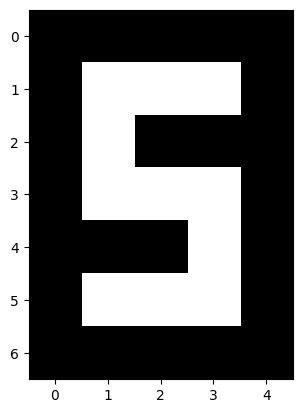

In [90]:
fig = plt.figure
plt.imshow(train_y_autoencoded[0].reshape((7, 5)), cmap='gray')
plt.show()

Реализуем необходимые функции активации нейроной для наших будущих слоёв


In [91]:
def relu(x: Nums):
    return x * (x > 0)


def drelu(x: Nums):
    # производная функции relu
    return x > 0


def sigmoid(x: Nums):
    return 1 / (1 + np.exp(-x))


def dsigmoid(x: Nums):
    s = sigmoid(x)
    return s * (1 - s)


def softmax(x: Nums):
    e_x = np.exp(x)
    sm = np.sum(e_x)
    return e_x / sm


def cross_entropy(pred: Nums, expected: Nums):
    # z - предсказанное, y - ожидаемое
    return -np.sum(expected * np.log(pred))


def error_function(pred: Nums, expected: Nums):
    # Получаем ошибку для последнего слоя нейросети
    return pred - expected

In [92]:
class OptimizerBase:
    def init_params(self, weights: Nums, bias: Nums):
        raise NotImplemented("init_params not implemented")
    
    def step(self, weights: Nums, bias: Nums, learning_rate: float, de_dW: Nums, de_dB: Nums) -> None:
        raise NotImplemented("step not implemented")

In [93]:
class NoOptimizer(OptimizerBase):
    def __init__(self, *args) -> None:
        pass

    def init_params(self, *args):
        pass

    def step(self, weights, bias, learning_rate: float, de_dW, de_dB) -> None:
        weights -= learning_rate * de_dW
        bias -= learning_rate * de_dB

In [94]:
class ImpulseOptimizer(OptimizerBase):
    def __init__(self, beta: float) -> None:
        self.beta = beta

    def init_params(self, weights: Nums, bias: Nums):
        self.v_dW = np.zeros_like(weights)
        self.v_dB = np.zeros_like(bias)

    def step(self, weights: Nums, bias: Nums, learning_rate: float, de_dW: Nums, de_dB: Nums) -> None:
        self.v_dW = self.beta * self.v_dW + (1 - self.beta) * de_dW
        self.v_dB = self.beta * self.v_dB + (1 - self.beta) * de_dB
        weights -= learning_rate * self.v_dW
        bias -= learning_rate * self.v_dB

In [95]:
class RMSPropOptimizer(OptimizerBase):
    def __init__(self, beta: float) -> None:
        self.beta = beta
    
    def init_params(self, weights: Nums, bias: Nums):
        self.v_dW = np.zeros_like(weights)
        self.v_dB = np.zeros_like(bias)

    def step(self, weights: Nums, bias: Nums, learning_rate: float, de_dW: Nums, de_dB: Nums) -> None:
        self.v_dW = self.beta * self.v_dW + (1 - self.beta) * np.square(de_dW)
        self.v_dB = self.beta * self.v_dB + (1 - self.beta) * np.square(de_dB)
        weights -= learning_rate * de_dW / (np.sqrt(self.v_dW) + 1e-4)
        bias -= learning_rate * de_dB / (np.sqrt(self.v_dB) + 1e-4)

In [96]:
class AdamOptimizer(OptimizerBase):
    def __init__(self, beta1: float, beta2: float) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.t = 1

    def init_params(self, weights: Nums, bias: Nums):
        self.v_dW = np.zeros_like(weights)
        self.v_dB = np.zeros_like(bias)

        self.s_dW = np.zeros_like(weights)
        self.s_dB = np.zeros_like(bias)

    def step(self, weights: Nums, bias: Nums, learning_rate: float, de_dW: Nums, de_dB: Nums) -> None:
        self.v_dW = self.beta1 * self.v_dW + (1 - self.beta1) * de_dW
        self.v_dB = self.beta1 * self.v_dB + (1 - self.beta1) * de_dB

        v_dW_corrected = self.v_dW / (1 - np.power(self.beta1, self.t))
        v_dB_corrected = self.v_dB / (1 - np.power(self.beta1, self.t))

        self.s_dW = self.beta2 * self.s_dW + (1 - self.beta2) * np.square(de_dW)
        self.s_dB = self.beta2 * self.s_dB + (1 - self.beta2) * np.square(de_dB)

        s_dW_corrected = self.s_dW / (1 - np.power(self.beta2, self.t))
        s_dB_corrected = self.s_dB / (1 - np.power(self.beta2, self.t))

        weights -= learning_rate * v_dW_corrected / np.sqrt(s_dW_corrected + 1e-8)
        bias -= learning_rate * v_dB_corrected / np.sqrt(s_dB_corrected + 1e-8)
        self.t += 1

Реализуем универсальный класс для линейного слоя


In [97]:
class Layer:
    """
    Реализует линейный слой в многослойном перцептроне

    input_size: int - количество входных нейронов
    output_size: int - количество выходных нейронов
    weights: np.ndarray[np.number] - веса слоя
    bias: np.ndarray[np.number] - смещения

    self.activation_function: NumsToNums - функция активации слоя
    self.activation_function_derivation: NumsToNums - производная функции активации слоя
    """

    def __init__(
        self,
        input_size: int,
        output_size: int,
        activation_function: Tuple[
            NumsToNums,
            NumsToNums,
        ],
        weights_initialize_function: Callable[[Tuple[int, int]], Nums] = None,
    ) -> None:
        """
        Args:
            input_size (int): размерность входных данных слоя
            output_size (int): размерность выходных данных слоя
            activation_function (NumsToNums, NumsToNums): кортеж из функции активации и её производной
            weights_initialize_function (Callable[[Tuple[int, int]], Nums]): функция инициализации весов,
            принимает кортеж shape
        """
        self.input_size = input_size
        self.output_size = output_size
        if weights_initialize_function is None:
            weights_initialize_function = np.random.random

        self.weights = weights_initialize_function((input_size, output_size))
        self.bias = weights_initialize_function((1, output_size))
        self.activation_function = activation_function[0]
        self.activation_function_derivation = activation_function[1]

        # Значения x и t, фиксируемые при forward, нужны для вычисления ошибки
        self._xt = ()
        """
        Контейнеры для хранения вычисленных ошибок для весов и смещений
        Необходимы для того, чтобы можно было обучать батчами
        
        В батче, для каждого примера необходимо вызвать forward и backward.
        В конце батча, для модификации весов, необходимо вызвать update
        _errors_log будет очищен
        """
        self._errors_log = ([], [])

    def forward(self, x: Nums) -> Nums:
        # линейное преобразование
        t = x @ self.weights + self.bias
        # нелинейное преобразование
        h = self.activation_function(t)

        # Записываем значения, необходимые для вычисления ошибки
        self._xt = (x, t)
        return h

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение ошибки
        Запоминает производные ошибки, но не изменяет параметры модели
        Для изменения нужно вызвать update
        """
        x, t = self._xt
        self._xt = ()

        de_dT = error * self.activation_function_derivation(t)
        de_dW = x.T @ de_dT
        de_dB = de_dT
        de_dX = de_dT @ self.weights.T
        self._errors_log[0].append(de_dW)
        self._errors_log[1].append(de_dB)
        return de_dX

    def update(self, learning_rate: float):
        """
        Модифицирует веса модели
        learning_rate: float, [0, 1] - на сколько сильно модель будет реагировать на ошибку
        """
        de_dWs, de_dBs = self._errors_log
        de_dW = np.sum(de_dWs, axis=0)
        de_dB = np.sum(de_dBs, axis=0)

        self.optimizer.step(self.weights, self.bias, learning_rate, de_dW, de_dB)

        self._errors_log = ([], [])

    def set_optimizer(self, optimizer: OptimizerBase):
        optimizer.init_params(self.weights, self.bias)
        self.optimizer = optimizer

    def __repr__(self) -> str:
        return f"<LinearLayer, {self.input_size}x{self.output_size}>"

Соответственно и общий класс для перцептрона с обучением по батчам


In [98]:
from typing import Any


class NN:
    """
    Полносвязная многослойная нейронная сеть
    """

    def __init__(
        self,
        layers: list[Layer],
        loss_function: NumsNumsToNums,
        error_function: NumsNumsToNums,
    ) -> None:
        self.layers = layers
        self.loss_function = loss_function  # Функция потерь
        self.error_function = (
            error_function  # Функция для получения ошибки для последнего слоя
        )

        # История значения loss_function, после train
        self.losses = []
        # Предсказания, полученные после train
        self.predicted = []

    def pop_loss(self, func: Callable[[Nums], Any]):
        loss = func(self.losses)
        self.losses.clear()
        return loss

    def forward(self, x: Nums) -> Nums:
        """
        Прямое распространение сети
        """
        current_x = x
        for layer in self.layers:
            current_x = layer.forward(current_x)

        return current_x

    def backward(self, error: Nums) -> Nums:
        """
        Обратное распространение сети, не меняет веса
        """
        current_error = error

        # Для последнего слоя ошибку получаем в error_function
        for layer in self.layers[::-1]:
            current_error = layer.backward(current_error)

        return current_error

    def update(self, learning_rate):
        """
        Модификация весов сети, все ошибки сохраняются в слои,
        стоит лишь вызвать данную функцию после однократного
        или серии применений (при batch) backward
        """
        for layer in self.layers[::-1]:
            layer.update(learning_rate)

    def train(
        self,
        xs: Nums,
        ys: Nums,
        optimizer_factory: Callable[[], OptimizerBase],
        learning_rate: float = 0.001,
        batch_size: int = 10,
    ):
        """
        Обучение сети в рамках одной эпохи
        """
        
        # Инициализируем экземпляры оптимизатора для каждого слоя
        for layer in self.layers:
            layer.set_optimizer(optimizer_factory())

        # Цикл по батчам, размера batch_size
        for batch_index in range(ceil(len(xs) / batch_size)):
            current_batch_slice = slice(
                batch_index * batch_size, (batch_index + 1) * batch_size
            )
            batch_xs = xs[current_batch_slice]
            batch_ys = ys[current_batch_slice]
            batch_losses = []  # Loss-ы одного батча

            for x, y in zip(batch_xs, batch_ys):
                x = x[None, ...]  # Для правильных размерностей (1, n), а не (n,)
                predict = self.forward(x)[0]
                error = self.error_function(predict, y)

                # Считаем ошибку
                self.backward(error)

                E = self.loss_function(predict, y)
                self.predicted.append(predict)
                batch_losses.append(E)

            # Обновляем веса
            self.update(learning_rate=learning_rate)

            # Собираем статистику
            batch_loss = np.sum(batch_losses)
            batch_losses.clear()
            self.losses.append(batch_loss)

In [99]:
network = NN(
    [
        Layer(784, 64, (sigmoid, dsigmoid),
            weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
        ),
        Layer(64, 35, (sigmoid, dsigmoid),
            weights_initialize_function=lambda shape: np.random.random(shape) * 0.01,
        ),
    ],
    loss_function=sklearn.metrics.root_mean_squared_error,
    error_function=error_function,
)

loss_history = []

Создадим экземпляр нашего перцептрона и обучим его


In [100]:
def train(
    network: NN,
    x: Nums,
    y: Nums,
    num_epoches: int,
    learning_rate: float,
    batch_size: int,
    loss_history: list
):
    bar = tqdm(range(1, num_epoches + 1), total=num_epoches)
    xy_indices = np.arange(len(x))
    for epoch in bar:
        network.predicted.clear()
        # В каждой эпохе изменим порядок обучающего датасета
        np.random.shuffle(xy_indices)

        # size - размер выборки для эпохи, ставлю 1000, чтобы быстрее видеть результат
        indices = np.random.choice(len(xy_indices), size=1000, replace=False)

        epoch_x = x[indices]
        epoch_y = y[indices]
        
        network.train(
            epoch_x,
            epoch_y,
            lambda: AdamOptimizer(0.4, 0.999),
            learning_rate=learning_rate,
            batch_size=batch_size,
        )
        
        # Средний loss за эпоху
        loss = network.pop_loss(np.mean)
        loss_history.append(loss)

        bar.set_description(
            f"epoch: {epoch}, loss: {loss:.10f}"
        )
        network.losses.clear()
    return loss_history


loss_history = train(
    network, train_x, train_y_autoencoded, 50, 0.005, 25, loss_history
)

epoch: 50, loss: 0.9643686044: 100%|██████████| 50/50 [00:26<00:00,  1.86it/s]


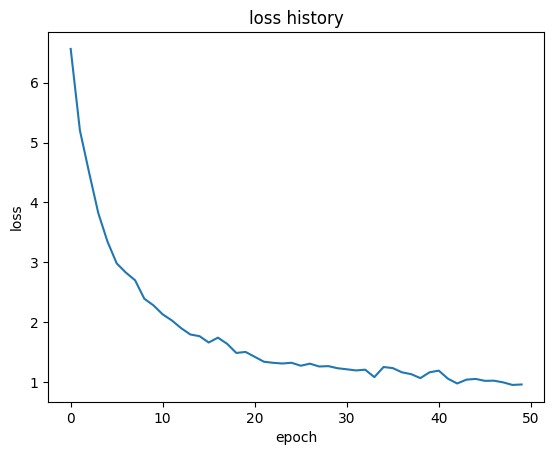

In [104]:
fig, ax = plt.subplots()

ax.plot(loss_history)
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_title("loss history")
plt.show()

In [105]:
pred_y = network.forward(test_x)
true_y = test_y_autoencoded

rmse = sklearn.metrics.root_mean_squared_error(true_y, pred_y)
print(f"RMSE на валидационной выборке: {rmse:.3f}")

RMSE на валидационной выборке: 0.036


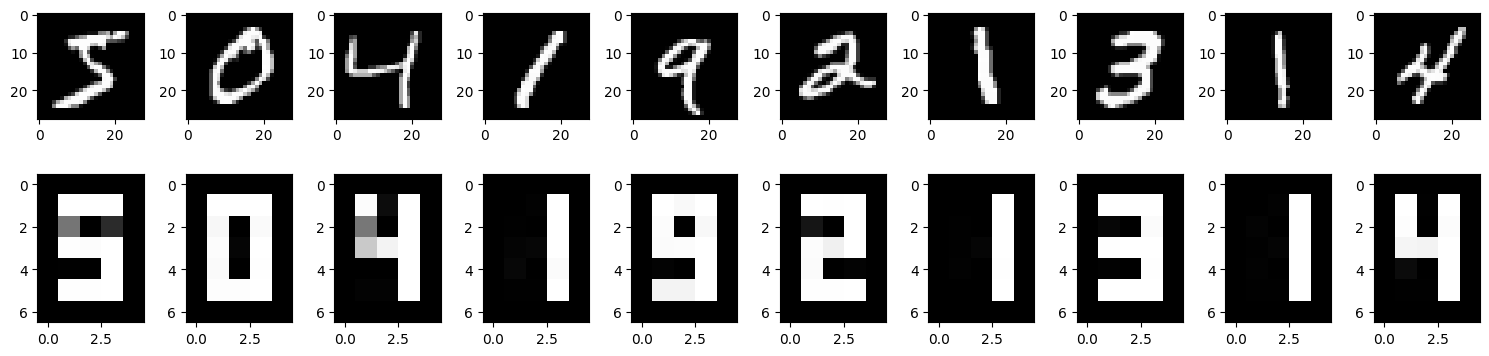

In [106]:
# выбираем 10 цифр из датасета для показа
slc = slice(0, 10)

num_row = 2
num_col = 10

# изначальный вариант
images1 = np.empty(10 * 784).reshape((10, 28, 28))
images1[:10] = train_x[slc].reshape((10, 28, 28))

# после кодировки
images2 = np.empty(10 * 7 * 5).reshape((10, 7, 5))
images2[:10] = network.forward(train_x[slc]).reshape((10, 7, 5))


fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(10):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(images1[i], cmap="gray")

for i in range(10, 20):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(images2[i - 10], cmap="gray")

plt.tight_layout()
plt.show()

Посмотрим на результат обучения на валидационной выборке


Ура!
